In [ ]:
!pip install -q transformers datasets peft accelerate bitsandbytes scipy torch trl
!pip install -q tensorboard

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 66.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import torch
from datasets import Dataset, concatenate_datasets
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    pipeline,
    logging,
)
import warnings
warnings.filterwarnings('ignore')
from peft import LoraConfig, PeftModel, get_peft_model, prepare_model_for_kbit_training
from trl import SFTTrainer
logging.set_verbosity_info()
print(f"GPU available: {torch.cuda.is_available()}")
print(f"CUDA device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")

GPU available: True
CUDA device: Tesla T4


In [ ]:
MODEL_NAME = "google/gemma-2-2b-it"
OUTPUT_DIR = "/content/drive/MyDrive/Thesis/finetune_gemma/output_gemma"
LORA_ALPHA = 16
LORA_DROPOUT = 0.1
LORA_R = 8

DATASET_PATHS = [
    "/content/dataset2.csv"
]

In [ ]:
def prepare_dataset(dataset_path):
    try:
        df = pd.read_csv(dataset_path)
        print(f"Dataset loaded from {dataset_path} with shape: {df.shape}")
        print(df.head())

        # Extract only Question and Answer columns
        if all(col in df.columns for col in ['Question', 'Answer']):
            df_filtered = df[['Question', 'Answer']]
        elif all(col in df.columns for col in ['question', 'answer']):
            df_filtered = df[['question', 'answer']]
            # Rename columns for consistency
            df_filtered = df_filtered.rename(columns={"question": "Question", "answer": "Answer"})
        else:
            raise ValueError(f"Dataset {dataset_path} doesn't have the required Question/Answer columns")

        # Create the dataset
        dataset_dict = {
            "question": df_filtered["Question"].tolist(),
            "answer": df_filtered["Answer"].tolist()
        }
        return Dataset.from_dict(dataset_dict)
    except Exception as e:
        print(f"Error loading dataset from {dataset_path}: {e}")
        return None

In [ ]:
datasets = []
for path in DATASET_PATHS:
    dataset = prepare_dataset(path)
    if dataset is not None:
        datasets.append(dataset)
        print(f"Successfully loaded dataset from {path} with {len(dataset)} examples")

if not datasets:
    raise ValueError("No valid datasets were loaded. Please check your dataset paths and formats.")

# Combine all datasets into one
if len(datasets) > 1:
    combined_dataset = concatenate_datasets(datasets)
    print(f"Combined dataset created with {len(combined_dataset)} examples")
else:
    combined_dataset = datasets[0]
    print(f"Single dataset used with {len(combined_dataset)} examples")

# Optional: Shuffle the combined dataset
combined_dataset = combined_dataset.shuffle(seed=42)

Dataset loaded from /content/dataset2.csv with shape: (15080, 4)
                                               input  \
0  I don't know how to cope with depression and f...   
1  I'm overwhelmed by constant worry and feeling ...   
2  I'm having trouble feeling hopeless and feelin...   
3  I'm having trouble anxiety and feeling unfocused.   
4  I'm feeling feeling hopeless and feeling reall...   

                                              output  \
0  That sounds like a lot to handle. How are you ...   
1  You are good enough just as you are. If you'd ...   
2  Burnout is really tough, and it’s important to...   
3  That sounds like a lot to handle. How are you ...   
4  Staying motivated can be tough when you’re fee...   

                                            Question  \
0  Tôi không biết làm thế nào để đối phó với chứn...   
1  Tôi bị choáng ngợp bởi sự lo lắng thường xuyên...   
2  Tôi khó có cảm giác tuyệt vọng và cảm thấy căn...   
3  Tôi đang gặp rắc rối với sự lo lắn

In [ ]:
for i in range(5):
    print(f"--- Example {i+1} ---")
    print("Question:", combined_dataset[i]['question'])
    print("Answer:", combined_dataset[i]['answer'])
    print()


--- Example 1 ---
Question: Tôi cảm thấy lạc lõng và cảm thấy choáng ngợp.
Answer: Tôi thực sự rất tiếc khi nghe điều đó. Đôi khi cảm thấy lo lắng cũng không sao. Bạn có muốn nói thêm về nó?

--- Example 2 ---
Question: Gần đây, tôi ngày càng trở nên sợ hãi các tình huống xã hội. Ý nghĩ phải nói chuyện với những người mới hoặc ở những nơi đông người khiến tôi kinh hãi. Tôi tránh những tình huống như vậy càng nhiều càng tốt, nhưng nó hạn chế khả năng tận hưởng cuộc sống một cách trọn vẹn của tôi. Tôi muốn vượt qua nỗi lo lắng xã hội này và có thể hòa nhập với người khác mà không sợ hãi.
Answer: Thật tuyệt khi bạn nhận ra mong muốn vượt qua nỗi lo lắng xã hội và hòa nhập với người khác mà không sợ hãi. Nỗi sợ hãi trước các tình huống xã hội có thể là một thách thức, nhưng có những chiến lược bạn có thể cố gắng kiểm soát và cuối cùng giảm bớt nỗi sợ hãi này.  Đầu tiên, hãy thực hiện những bước nhỏ để đối mặt với nỗi sợ hãi của bạn. Bắt đầu bằng cách tiếp xúc với những tình huống xã hội ít

In [ ]:
from getpass import getpass
from huggingface_hub import login
hf_token = getpass("Nhập Hugging Face token của bạn: ")
login(hf_token)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

# Configure quantization
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
)

# Load the model with quantization
print("Loading model. This may take a few minutes...")
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True
)

# Prepare the model for training
model = prepare_model_for_kbit_training(model)

# Define LoRA configuration
lora_config = LoraConfig(
    r=LORA_R,
    lora_alpha=LORA_ALPHA,
    lora_dropout=LORA_DROPOUT,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
)
model = get_peft_model(model, lora_config)
print(f"Trainable parameters: {model.print_trainable_parameters()}")

Nhập Hugging Face token của bạn: ··········


tokenizer_config.json:   0%|          | 0.00/47.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

loading file tokenizer.model from cache at /root/.cache/huggingface/hub/models--google--gemma-2-2b-it/snapshots/299a8560bedf22ed1c72a8a11e7dce4a7f9f51f8/tokenizer.model
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--google--gemma-2-2b-it/snapshots/299a8560bedf22ed1c72a8a11e7dce4a7f9f51f8/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--google--gemma-2-2b-it/snapshots/299a8560bedf22ed1c72a8a11e7dce4a7f9f51f8/special_tokens_map.json
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--google--gemma-2-2b-it/snapshots/299a8560bedf22ed1c72a8a11e7dce4a7f9f51f8/tokenizer_config.json
loading file chat_template.jinja from cache at None


Loading model. This may take a few minutes...


config.json:   0%|          | 0.00/838 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--gemma-2-2b-it/snapshots/299a8560bedf22ed1c72a8a11e7dce4a7f9f51f8/config.json
Model config Gemma2Config {
  "architectures": [
    "Gemma2ForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "attn_logit_softcapping": 50.0,
  "bos_token_id": 2,
  "cache_implementation": "hybrid",
  "eos_token_id": [
    1,
    107
  ],
  "final_logit_softcapping": 30.0,
  "head_dim": 256,
  "hidden_act": "gelu_pytorch_tanh",
  "hidden_activation": "gelu_pytorch_tanh",
  "hidden_size": 2304,
  "initializer_range": 0.02,
  "intermediate_size": 9216,
  "max_position_embeddings": 8192,
  "model_type": "gemma2",
  "num_attention_heads": 8,
  "num_hidden_layers": 26,
  "num_key_value_heads": 4,
  "pad_token_id": 0,
  "query_pre_attn_scalar": 256,
  "rms_norm_eps": 1e-06,
  "rope_theta": 10000.0,
  "sliding_window": 4096,
  "torch_dtype": "bfloat16",
  "transformers_version": "4.51.3",
  "use_

model.safetensors.index.json:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--google--gemma-2-2b-it/snapshots/299a8560bedf22ed1c72a8a11e7dce4a7f9f51f8/model.safetensors.index.json


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/241M [00:00<?, ?B/s]

Instantiating Gemma2ForCausalLM model under default dtype torch.float16.
Generate config GenerationConfig {
  "bos_token_id": 2,
  "cache_implementation": "hybrid",
  "eos_token_id": [
    1,
    107
  ],
  "pad_token_id": 0
}

target_dtype {target_dtype} is replaced by `CustomDtype.INT4` for 4-bit BnB quantization


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

All model checkpoint weights were used when initializing Gemma2ForCausalLM.

All the weights of Gemma2ForCausalLM were initialized from the model checkpoint at google/gemma-2-2b-it.
If your task is similar to the task the model of the checkpoint was trained on, you can already use Gemma2ForCausalLM for predictions without further training.


generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

loading configuration file generation_config.json from cache at /root/.cache/huggingface/hub/models--google--gemma-2-2b-it/snapshots/299a8560bedf22ed1c72a8a11e7dce4a7f9f51f8/generation_config.json
Generate config GenerationConfig {
  "bos_token_id": 2,
  "cache_implementation": "hybrid",
  "eos_token_id": [
    1,
    107
  ],
  "pad_token_id": 0
}



trainable params: 10,383,360 || all params: 2,624,725,248 || trainable%: 0.3956
Trainable parameters: None


In [ ]:
def formatting_prompts_func(example):
    q = example["question"]
    a = example["answer"]

    # Prompt chung thêm vào đầu câu trả lời
    system_prompt = "Bạn là chatbot AI tư vấn về sức khỏe tinh thần cho bệnh nhân, hãy đưa ra câu trả lời một cách ân cần, gần gũi và đồng cảm với bệnh nhân. Khi kết thúc câu trả lời hãy cho bệnh nhân những lời khuyên chân thành nhất."

    # Combine prompt chung với câu hỏi và câu trả lời
    return {"text": f"{system_prompt}\n\nQuestion: {q}\nAnswer: {a}"}

combined_dataset = combined_dataset.map(formatting_prompts_func)
print(combined_dataset[0])

Map:   0%|          | 0/15080 [00:00<?, ? examples/s]

{'question': 'Tôi cảm thấy lòng tự trọng bị hạ thấp và cảm thấy lạc lõng.', 'answer': 'Nghe có vẻ có rất nhiều việc phải xử lý. Bạn đối mặt với mọi chuyện xảy ra trong cuộc sống như thế nào?', 'text': 'Bạn là chatbot AI tư vấn về sức khỏe tinh thần cho bệnh nhân, hãy đưa ra câu trả lời một cách ân cần, gần gũi và đồng cảm với bệnh nhân. Khi kết thúc câu trả lời hãy cho bệnh nhân những lời khuyên chân thành nhất.\n\nQuestion: Tôi cảm thấy lòng tự trọng bị hạ thấp và cảm thấy lạc lõng.\nAnswer: Nghe có vẻ có rất nhiều việc phải xử lý. Bạn đối mặt với mọi chuyện xảy ra trong cuộc sống như thế nào?'}


In [ ]:
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    max_steps=1000,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8,
    gradient_checkpointing=True,
    save_steps=200,
    logging_steps=10,
    learning_rate=2e-4,
    weight_decay=0.01,
    fp16=True,
    optim="paged_adamw_8bit",
    lr_scheduler_type="cosine",
    warmup_ratio=0.05,
    report_to="none",
)

# Create SFT trainer
trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=combined_dataset,
)

# Train the model
print("Starting training...")
trainer.train()

# Save the trained model
print("Saving model...")
trainer.save_model()

PyTorch: setting up devices
PyTorch: setting up devices
loading file tokenizer.model from cache at /root/.cache/huggingface/hub/models--google--gemma-2-2b-it/snapshots/299a8560bedf22ed1c72a8a11e7dce4a7f9f51f8/tokenizer.model
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--google--gemma-2-2b-it/snapshots/299a8560bedf22ed1c72a8a11e7dce4a7f9f51f8/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--google--gemma-2-2b-it/snapshots/299a8560bedf22ed1c72a8a11e7dce4a7f9f51f8/special_tokens_map.json
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--google--gemma-2-2b-it/snapshots/299a8560bedf22ed1c72a8a11e7dce4a7f9f51f8/tokenizer_config.json
loading file chat_template.jinja from cache at None


Converting train dataset to ChatML:   0%|          | 0/15080 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/15080 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/15080 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/15080 [00:00<?, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs
Using auto half precision backend
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text, answer, question. If text, answer, question are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 15,080
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 8
  Total optimization steps = 1,000
  Number of trainable parameters = 10,383,360


Starting training...


It is strongly recommended to train Gemma2 models with the `eager` attention implementation instead of `sdpa`. Use `eager` with `AutoModelForCausalLM.from_pretrained('<path-to-checkpoint>', attn_implementation='eager')`.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss
10,2.666600
20,1.526700
30,0.771400
40,0.448200
50,0.247800
60,0.174800
70,0.155200
80,0.224400
90,0.150200
100,0.135300


Saving model checkpoint to /content/drive/MyDrive/Thesis/finetune_gemma/output_gemma/checkpoint-200
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--gemma-2-2b-it/snapshots/299a8560bedf22ed1c72a8a11e7dce4a7f9f51f8/config.json
Model config Gemma2Config {
  "architectures": [
    "Gemma2ForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "attn_logit_softcapping": 50.0,
  "bos_token_id": 2,
  "cache_implementation": "hybrid",
  "eos_token_id": [
    1,
    107
  ],
  "final_logit_softcapping": 30.0,
  "head_dim": 256,
  "hidden_act": "gelu_pytorch_tanh",
  "hidden_activation": "gelu_pytorch_tanh",
  "hidden_size": 2304,
  "initializer_range": 0.02,
  "intermediate_size": 9216,
  "max_position_embeddings": 8192,
  "model_type": "gemma2",
  "num_attention_heads": 8,
  "num_hidden_layers": 26,
  "num_key_value_heads": 4,
  "pad_token_id": 0,
  "query_pre_attn_scalar": 256,
  "rms_norm_eps": 1e-06,
  "rope_theta": 10000.0

Saving model...


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--gemma-2-2b-it/snapshots/299a8560bedf22ed1c72a8a11e7dce4a7f9f51f8/config.json
Model config Gemma2Config {
  "architectures": [
    "Gemma2ForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "attn_logit_softcapping": 50.0,
  "bos_token_id": 2,
  "cache_implementation": "hybrid",
  "eos_token_id": [
    1,
    107
  ],
  "final_logit_softcapping": 30.0,
  "head_dim": 256,
  "hidden_act": "gelu_pytorch_tanh",
  "hidden_activation": "gelu_pytorch_tanh",
  "hidden_size": 2304,
  "initializer_range": 0.02,
  "intermediate_size": 9216,
  "max_position_embeddings": 8192,
  "model_type": "gemma2",
  "num_attention_heads": 8,
  "num_hidden_layers": 26,
  "num_key_value_heads": 4,
  "pad_token_id": 0,
  "query_pre_attn_scalar": 256,
  "rms_norm_eps": 1e-06,
  "rope_theta": 10000.0,
  "sliding_window": 4096,
  "torch_dtype": "bfloat16",
  "transformers_version": "4.51.3",
  "use_

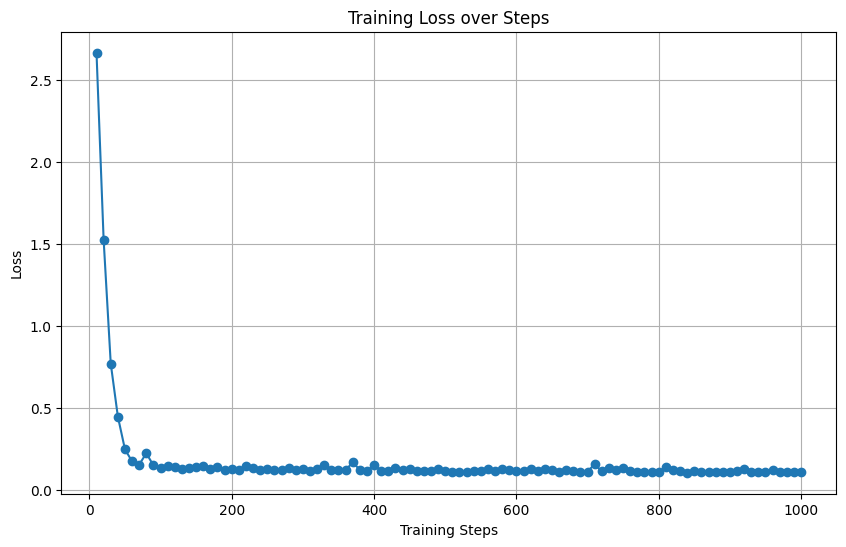

In [ ]:
import matplotlib.pyplot as plt

# Lấy log history từ trainer
logs = trainer.state.log_history

# Trích xuất loss và step từ log
steps = []
losses = []

for log in logs:
    if "loss" in log and "step" in log:
        steps.append(log["step"])
        losses.append(log["loss"])

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.plot(steps, losses, marker='o')
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training Loss over Steps")
plt.grid(True)
plt.show()

In [ ]:
from transformers import BitsAndBytesConfig
import torch

def save_merged_model(model_path, save_path):
    print(f"Creating merged model at {save_path}...")

    # Cấu hình quantization 4-bit
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,              # Kích hoạt quantization 4-bit
        bnb_4bit_quant_type="nf4",      # Loại quantization (nf4 hoặc fp4)
        bnb_4bit_use_double_quant=True, # Sử dụng double quantization để tiết kiệm thêm bộ nhớ
        bnb_4bit_compute_dtype=torch.bfloat16  # Kiểu dữ liệu tính toán (float16 hoặc bfloat16)
    )

    # Load base model với quantization 4-bit
    base_model = AutoModelForCausalLM.from_pretrained(
        MODEL_NAME,
        quantization_config=bnb_config,  # Áp dụng cấu hình 4-bit
        device_map="auto",
        trust_remote_code=True
    )

    # Load LoRA adapter
    model = PeftModel.from_pretrained(base_model, model_path)

    # Merge LoRA vào base model
    merged_model = model.merge_and_unload()

    # Lưu model đã merged
    merged_model.save_pretrained(save_path)
    tokenizer.save_pretrained(save_path)

    print(f"Merged model saved to {save_path}")

# Gọi hàm để lưu model
save_merged_model(OUTPUT_DIR, "/content/drive/MyDrive/Thesis/finetune_gemma/finetune_gemma")
print("Process completed successfully!")

Creating merged model at /content/drive/MyDrive/Thesis/finetune_gemma/finetune_gemma...


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--gemma-2-2b-it/snapshots/299a8560bedf22ed1c72a8a11e7dce4a7f9f51f8/config.json
Model config Gemma2Config {
  "architectures": [
    "Gemma2ForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "attn_logit_softcapping": 50.0,
  "bos_token_id": 2,
  "cache_implementation": "hybrid",
  "eos_token_id": [
    1,
    107
  ],
  "final_logit_softcapping": 30.0,
  "head_dim": 256,
  "hidden_act": "gelu_pytorch_tanh",
  "hidden_activation": "gelu_pytorch_tanh",
  "hidden_size": 2304,
  "initializer_range": 0.02,
  "intermediate_size": 9216,
  "max_position_embeddings": 8192,
  "model_type": "gemma2",
  "num_attention_heads": 8,
  "num_hidden_layers": 26,
  "num_key_value_heads": 4,
  "pad_token_id": 0,
  "query_pre_attn_scalar": 256,
  "rms_norm_eps": 1e-06,
  "rope_theta": 10000.0,
  "sliding_window": 4096,
  "torch_dtype": "bfloat16",
  "transformers_version": "4.51.3",
  "use_

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

All model checkpoint weights were used when initializing Gemma2ForCausalLM.

All the weights of Gemma2ForCausalLM were initialized from the model checkpoint at google/gemma-2-2b-it.
If your task is similar to the task the model of the checkpoint was trained on, you can already use Gemma2ForCausalLM for predictions without further training.
loading configuration file generation_config.json from cache at /root/.cache/huggingface/hub/models--google--gemma-2-2b-it/snapshots/299a8560bedf22ed1c72a8a11e7dce4a7f9f51f8/generation_config.json
Generate config GenerationConfig {
  "bos_token_id": 2,
  "cache_implementation": "hybrid",
  "eos_token_id": [
    1,
    107
  ],
  "pad_token_id": 0
}

Configuration saved in /content/drive/MyDrive/Thesis/finetune_gemma/finetune_gemma/config.json
Configuration saved in /content/drive/MyDrive/Thesis/finetune_gemma/finetune_gemma/generation_config.json
Model weights saved in /content/drive/MyDrive/Thesis/finetune_gemma/finetune_gemma/model.safetensors
toke

Merged model saved to /content/drive/MyDrive/Thesis/finetune_gemma/finetune_gemma
Process completed successfully!


In [ ]:
!pip install nltk sacrebleu sacremoses nltk

In [ ]:
# Thêm các thư viện cần thiết cho BLEU và METEOR
import nltk
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu
from nltk.translate.meteor_score import single_meteor_score, meteor_score
import sacrebleu
import numpy as np

# Download NLTK data cần thiết cho METEOR
nltk.download('wordnet')
nltk.download('omw-1.4')

# Hàm đánh giá với BLEU và METEOR
def evaluate_with_metrics(generated_texts, reference_texts):
    """
    Đánh giá chất lượng văn bản được sinh ra với nhiều metric khác nhau

    Parameters:
    - generated_texts: list of str, văn bản được sinh ra bởi mô hình
    - reference_texts: list of str, văn bản tham chiếu

    Returns:
    - dict, kết quả đánh giá từ các metrics khác nhau
    """
    results = {}

    # Chuẩn bị dữ liệu cho BLEU
    references_tokenized = []
    candidates_tokenized = []

    for ref, gen in zip(reference_texts, generated_texts):
        # Tokenize reference và generated text
        ref_tokens = ref.split()
        gen_tokens = gen.split()

        references_tokenized.append([ref_tokens])  # BLEU yêu cầu list của list
        candidates_tokenized.append(gen_tokens)

    # 1. Tính BLEU score với NLTK
    try:
        bleu_score = corpus_bleu(references_tokenized, candidates_tokenized)
        results['bleu_nltk'] = bleu_score

        # Tính các n-gram BLEU scores riêng
        bleu_1 = corpus_bleu(references_tokenized, candidates_tokenized,
                           weights=(1, 0, 0, 0))
        bleu_2 = corpus_bleu(references_tokenized, candidates_tokenized,
                           weights=(0.5, 0.5, 0, 0))
        bleu_3 = corpus_bleu(references_tokenized, candidates_tokenized,
                           weights=(0.33, 0.33, 0.33, 0))
        bleu_4 = corpus_bleu(references_tokenized, candidates_tokenized,
                           weights=(0.25, 0.25, 0.25, 0.25))

        results['bleu_1'] = bleu_1
        results['bleu_2'] = bleu_2
        results['bleu_3'] = bleu_3
        results['bleu_4'] = bleu_4
    except Exception as e:
        print(f"Lỗi khi tính BLEU score: {e}")
        results['bleu_error'] = str(e)

    # 2. Tính BLEU score với sacrebleu (phiên bản chuẩn hơn)
    try:
        sacrebleu_score = sacrebleu.corpus_bleu(generated_texts, [reference_texts])
        results['sacrebleu'] = sacrebleu_score.score
    except Exception as e:
        print(f"Lỗi khi tính sacrebleu score: {e}")
        results['sacrebleu_error'] = str(e)

    # 3. Tính METEOR score
    try:
        meteor_scores = []
        for ref, gen in zip(reference_texts, generated_texts):
            # Tokenize reference và generated text
            ref_tokens = ref.split()
            gen_tokens = gen.split()

            # Tính METEOR cho mỗi cặp văn bản
            score = single_meteor_score(ref_tokens, gen_tokens)
            meteor_scores.append(score)

        # Tính trung bình METEOR trên toàn bộ corpus
        results['meteor'] = np.mean(meteor_scores)
    except Exception as e:
        print(f"Lỗi khi tính METEOR score: {e}")
        results['meteor_error'] = str(e)

    return results

# Hàm đánh giá tổng hợp với tất cả các metrics (ROUGE, BLEU, METEOR)
def comprehensive_evaluation(model, tokenizer, test_dataset, num_samples=10):
    """
    Đánh giá mô hình với nhiều metrics khác nhau

    Parameters:
    - model: mô hình đã được huấn luyện
    - tokenizer: tokenizer cho mô hình
    - test_dataset: tập dữ liệu kiểm thử
    - num_samples: số lượng mẫu sử dụng để đánh giá

    Returns:
    - dict, kết quả đánh giá từ các metrics khác nhau
    """
    # Khởi tạo pipeline sinh văn bản
    generator = pipeline("text-generation", model=model, tokenizer=tokenizer)

    # Lấy mẫu từ tập kiểm thử
    samples = test_dataset.select(range(min(num_samples, len(test_dataset))))
    prompts = [sample["prompt"] for sample in samples]
    references = [sample["completion"] for sample in samples]

    # Sinh văn bản từ mô hình
    generations = []
    for prompt in prompts:
        try:
            output = generator(prompt, max_length=1024, do_sample=True, temperature=0.7)
            generated_text = output[0]['generated_text']

            # Loại bỏ prompt từ văn bản được sinh để đánh giá chỉ phần completion
            if prompt in generated_text:
                generated_text = generated_text[len(prompt):].strip()

            generations.append(generated_text)

            print(f"Prompt: {prompt[:100]}...")
            print(f"Generated: {generated_text[:100]}...")
            print("-" * 50)
        except Exception as e:
            print(f"Lỗi khi sinh văn bản: {e}")
            generations.append("")  # Thêm chuỗi rỗng nếu có lỗi

    # Tính ROUGE scores
    try:
        from rouge import Rouge
        rouge = Rouge()
        rouge_scores = rouge.get_scores(generations, references, avg=True)
    except Exception as e:
        print(f"Lỗi khi tính ROUGE: {e}")
        rouge_scores = {"error": str(e)}

    # Tính BLEU và METEOR scores
    other_metrics = evaluate_with_metrics(generations, references)

    # Kết hợp tất cả metrics
    all_metrics = {
        "rouge": rouge_scores,
        **other_metrics
    }

    return all_metrics

# Sử dụng hàm đánh giá tổng hợp
print("Đánh giá mô hình với ROUGE, BLEU và METEOR...")
evaluation_results = comprehensive_evaluation(
    model=trainer.model,
    tokenizer=tokenizer,
    test_dataset=val_dataset,
    num_samples=20  # Số lượng mẫu để đánh giá
)

print("\n===== KẾT QUẢ ĐÁNH GIÁ =====")
print("ROUGE Scores:")
print(evaluation_results["rouge"])
print("\nBLEU Scores:")
print(f"BLEU-1: {evaluation_results['bleu_1']:.4f}")
print(f"BLEU-2: {evaluation_results['bleu_2']:.4f}")
print(f"BLEU-3: {evaluation_results['bleu_3']:.4f}")
print(f"BLEU-4: {evaluation_results['bleu_4']:.4f}")
print(f"SacreBLEU: {evaluation_results['sacrebleu']:.4f}")
print("\nMETEOR Score:")
print(f"METEOR: {evaluation_results['meteor']:.4f}")

# Lưu kết quả đánh giá vào file
import json
import os

os.makedirs("evaluation_results", exist_ok=True)
with open("evaluation_results/metrics.json", "w") as f:
    json.dump(evaluation_results, f, indent=2)

print("\nKết quả đánh giá đã được lưu vào file evaluation_results/metrics.json")

In [ ]:
!zip -r /content/drive/MyDrive/Thesis/finetune/mistral-7B-finetune.zip /content/drive/MyDrive/Thesis/finetune/mistral-7B-finetune

  adding: content/drive/MyDrive/Thesis/finetune/mistral-7B-finetune/ (stored 0%)
  adding: content/drive/MyDrive/Thesis/finetune/mistral-7B-finetune/config.json (deflated 54%)
  adding: content/drive/MyDrive/Thesis/finetune/mistral-7B-finetune/generation_config.json (deflated 20%)
  adding: content/drive/MyDrive/Thesis/finetune/mistral-7B-finetune/model.safetensors (deflated 6%)
  adding: content/drive/MyDrive/Thesis/finetune/mistral-7B-finetune/tokenizer_config.json (deflated 95%)
  adding: content/drive/MyDrive/Thesis/finetune/mistral-7B-finetune/special_tokens_map.json (deflated 73%)
  adding: content/drive/MyDrive/Thesis/finetune/mistral-7B-finetune/tokenizer.model (deflated 61%)
  adding: content/drive/MyDrive/Thesis/finetune/mistral-7B-finetune/tokenizer.json (deflated 85%)


In [ ]:
from google.colab import files
files.download("/content/drive/MyDrive/Thesis/finetune/mistral-7B-finetune.zip")